In [67]:
# Se importan las librerías a usar
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score as ss
import itertools

# Estudio de la dependencia de combustibles fósiles
## ¿De qué fuentes proviene la electricidad que consume cada país?

La electricidad obtenida a partir de fuentes energéticas fósiles (gas, petróleo y carbón) conlleva un aumento en las emisiones de gases de efecto invernadero como el dióxido de carbono, fuertemente implicados en el cambio climático global. <br>
Tanto las fuentes renovables (solar, eólica e hidroeléctrica) como la nuclear son consideradas bajas en carbono ya que no aumentan las emisiones de dióxido de carbono. <br>
En el marco de los esfuerzos globales por reducir el impacto ambiental y la huella de carbono, se han firmado acuerdos internacionales que comprometen a los países en buscar una transición energética que permita reducir la dependencia de energías de origen fósil. <br>
En este informe buscamos evaluar el nivel de dependencia de combustibles fósiles para electricidad de cada país del mundo, agrupándolos según las fuentes de las que proviene la electricidad que consumen.


### **Objetivo:** Evaluar el nivel de dependencia de combustibles fósiles para electricidad de cada país del mundo <br>
Se toman los datos promedio para cada país entre los años de 2010 a 2020 (para más detalles ver notebook EDA).<br>
Se corre un modelo no supervisado usando un algoritmo DBSCAN. 

## 1. Importación y visualización de datos

# ACLARAR UNIDADES

Importamos el dataset. 

In [68]:
df = pd.read_csv(r"../datasets/wec_ns.csv")
df.head(5)

,country,population,low_carbon_share_elec,fossil_share_elec,renewables_share_elec,nuclear_share_elec,fossil_cons_per_capita,per_capita_electricity,continente,iso_code
0,Afghanistan,34.247333,83.543444,16.456556,83.543444,0.0,5.156111,31.813000,Asia,AFG
1,Albania,2.896444,99.851444,0.148556,99.851444,0.0,2.103889,1998.432000,Europa,ALB
2,Algeria,39.784222,0.766333,99.233667,0.766333,0.0,1568.103333,1580.157222,África,DZA
3,American Samoa,0.055778,0.000000,100.000000,0.000000,0.0,2888.744333,2888.744333,Oceanía,ASM
4,Angola,27.940556,65.673556,34.326444,65.673556,0.0,110.650000,326.007889,África,AGO


In [69]:
fig1 = px.scatter(x=df["fossil_share_elec"], y=df["renewables_share_elec"])
fig1.update_layout(xaxis_title="Porcentaje de fuente fósil", yaxis_title="Porcentaje de fuente renovable",)
fig1.update_layout(title="Proporción de electricidad de fuentes renovables vs fuentes fósiles ",)

Aunque los puntos forman una recta, no nos interesa modelarlo como regresión lineal ya que conocemos la formula que siguen: <br> 
porcentaje fosil + porcentaje renovables + procentaje nuclear = 100. 

Por lo que es esperable que al aumentar, por ejemplo, el porcentaje de fuente renovable disminuya el porcentaje de fuente fósil, lo que lleva a la formación de la recta que se observa en el gráfico. Sin embargo, vemos también que algunos puntos se desvian de la recta. <br>

In [70]:
fig2 = px.scatter(x=df["nuclear_share_elec"], y=df["renewables_share_elec"])
fig2.update_layout(xaxis_title="Porcentaje de fuente nuclear", yaxis_title="Porcentaje de fuente renovable",)
fig2.update_layout(title="Proporción de electricidad de fuentes renovables vs fuente nuclear ",)

Vemos que la mayoría de los países aparecen como una recta vertical en el 0 del eje X: son aquellos países que no consumen electricidad de fuentes nucleares. Vemos también que otros países muestran diversos porcentajes de electricidad de fuente nuclear. 

Usaremos el algoritmo de clustering por DBSCAN para agrupar a los países según su distribución de fuentes de electricidad. 

## 2. Función de optimización de DBSCAN

El siguiente código define una función que permite poner a prueba muchos modelos de DBSCAN con distintos parámetros y calcular su score de silhouette para hallar la combinación de parámetros que devuelve el modelo con score máximo. 

Primero especificamos las combinaciones de epsilon y min_sample que queremos probar.  

In [71]:
epsilons = np.linspace(0.01, 1, num=30)
epsilons

array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])

In [72]:
min_samples = np.arange(2, 20, step=1)
min_samples

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

In [73]:
combinations = list(itertools.product(epsilons, min_samples))

Cantidad de combinaciones de parámetros que se van a probar:

In [74]:
N = len(combinations)
print(f"Se pondran a prueba {N} combinaciones de {len(epsilons)} valores de epsilon y {len(min_samples)} valores de min_samples.")

Se pondran a prueba 540 combinaciones de 30 valores de epsilon y 18 valores de min_samples.


Definimos la función:

In [75]:
def get_scores_and_labels(combinations, X):
  ''' Calcula parametros optimos de DBSCAN para maximixar score de silhouette. 
  combinations: lista de combinaciones de epsilons y min_samples a probar. 
  X: numpy.array de variables a modelar. 
  '''
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue

    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'epsilon_optimo': best_parameters[0],
          'min_samples_optimo': best_parameters[1],
          'etiquetas_optimas': best_labels,
          'score_maximo': best_score}

## 3. Modelo

Creamos una variable con las columnas de interés. 

In [76]:
features = ["fossil_share_elec", "renewables_share_elec","nuclear_share_elec"]
X = df[features]
X.head(5)

,fossil_share_elec,renewables_share_elec,nuclear_share_elec
0,16.456556,83.543444,0.0
1,0.148556,99.851444,0.0
2,99.233667,0.766333,0.0
3,100.000000,0.000000,0.0
4,34.326444,65.673556,0.0


Escalamos las variables para evitar que una tenga más peso que otra simplemente por su magnitud.

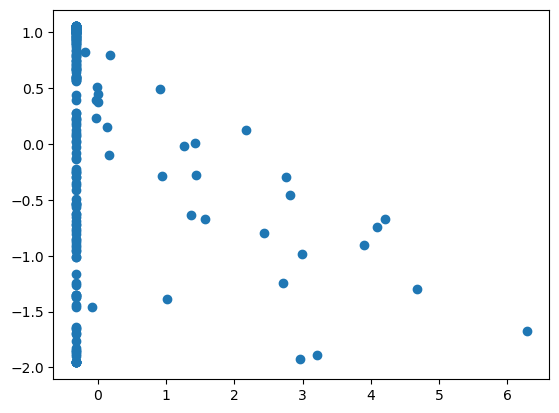

In [77]:
X_scaled = StandardScaler().fit_transform(X)
plt.scatter(X_scaled[:, 2], X_scaled[:, 0])

Usamos la función `get_scores_and_labels()` para poner a prueba las distintas combinaciones de parámetros y encontrar el modelo con mayor score. 

In [78]:
mejor_score = get_scores_and_labels(combinations, X_scaled)

Index: 0, Score: 0.1075484863198379, Labels: [-1  0  1  1 -1  2 -1 -1  3  3 -1 -1  1  1  2  2  2 -1  4  5  1  0 -1 -1
  1 -1  1  1 -1  6  7 -1 -1 -1  1  4  2 -1 -1 -1  5 -1  8 -1 -1 -1 -1 -1
  0 -1  1  9 -1 -1 -1 -1 10  5  3  0 11 -1 -1 -1 -1 -1  1 12 -1 11  1 13
  7  2 14  2 -1 15  2  2  6 -1  1 -1  0 -1 -1 -1 -1 -1  2 -1 16 -1 17 18
 12 18  1 19 -1 -1  5  0  1  1 -1 -1 20 19 14  1 -1 21  5 -1 -1 -1 -1 22
 23  1  6 -1 -1  1  0 -1  6 12 15  2 -1  1 -1 -1  1 -1  1 -1 10  0 -1 13
 14 -1 17  1 -1 -1 -1  1  5  1  2  6 -1 16  1  8 -1  1 24  5 -1 -1 -1  5
 -1 -1  1 -1 -1 24 20 -1 -1 21 -1 -1 -1 14 -1  1  1  5  9  1  1 -1 -1  1
 -1 -1  1 -1 -1  6 -1 -1 22 -1 23], NumClusters: 25
Index: 1, Score: -0.048734154139249676, Labels: [-1  0  1  1 -1  2 -1 -1  3  3 -1 -1  1  1  2  2  2 -1 -1  4  1  0 -1 -1
  1 -1  1  1 -1  5 -1 -1 -1 -1  1 -1  2 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1
  0 -1  1 -1 -1 -1 -1 -1 -1  4  3  0 -1 -1 -1 -1 -1 -1  1  6 -1 -1  1 -1
 -1  2  7  2 -1 -1  2  2  5 -1  1 -1  0 -1 -1 -1 -1 

In [79]:
mejor_score

{'epsilon_optimo': 0.14655172413793105,
 'min_samples_optimo': 5,
 'etiquetas_optimas': array([ 4,  0,  1,  1,  2,  1, -1, -1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        -1,  0,  1,  1,  0,  3,  3,  1, -1,  1,  1, -1,  1,  4,  3,  2, -1,
         1,  0,  1,  3, -1,  4,  1,  3,  1,  0,  2,  1,  1, -1,  0,  2,  1,
         3,  1,  2,  1,  2,  3,  1,  1,  0,  2, -1, -1,  2,  3,  3,  1,  4,
        -1,  2,  1,  3,  4,  1,  1,  1,  2,  2,  1,  1,  1,  2,  1, -1,  0,
        -1,  1,  1,  1,  3,  1,  3,  1, -1,  1,  1,  4,  1,  1,  0,  4,  2,
         1,  0,  1,  1,  2,  3,  3,  0,  1,  1,  2,  1,  1,  3, -1, -1,  1,
         1,  2,  1,  1,  0,  0,  1,  0, -1,  1,  4,  2,  1, -1,  1,  4,  0,
         1, -1,  1,  2,  3,  0,  2,  3,  1,  2,  1,  1, -1, -1,  2,  1,  1,
         1,  1,  1,  3,  1,  1,  1,  3,  1,  2,  1, -1, -1,  1,  1, -1, -1,
         1, -1,  3,  2,  3, -1, -1,  1, -1,  0,  3,  1,  3,  1,  1,  1,  3,
         1,  1,  0, -1,  1, -1, -1,  1,  0,  1,  1,  2,  3,  1,  0,  2],
    

Encontramos los parámetros que generan el modelo con mayor score. 

## 4. Identificación de clusters

In [80]:
df['cluster'] = mejor_score['etiquetas_optimas']
df['cluster'].value_counts()

 1    91
-1    32
 2    25
 3    25
 0    20
 4    10
Name: cluster, dtype: int64

## 5. Visualización de clusters

In [81]:
fig = px.scatter(x=df["fossil_share_elec"], y=df["renewables_share_elec"], color=df['cluster'])
fig.update_layout(xaxis_title="Porcentaje de fuente fosil",yaxis_title="Porcentaje de fuente renovable")
fig.update_layout(title="Proporcion de electricidad de fuentes renovables vs fuentes fosiles",)
fig.show()

Podemos agrupar los países del mundo según su dependencia de las fuentes fósiles para electricidad. <br>
Magenta (cluster0) --> Totalmente dependiente de fuentes fósiles <br>
Naranja (cluster4) --> Fuertemente dependiente de fuentes fósiles <br>
Rojo (cluster2) --> Moderadamente dependiente de fuentes fósiles <br>
Amarillo (cluster3) --> Levemente dependiente de fuentes fósiles <br>
Violeta (cluster1) --> En camino a independencia de fuentes fósiles<br>

In [82]:
fig = px.scatter(x=df["nuclear_share_elec"], y=df["renewables_share_elec"], color=df['cluster'])
fig.update_layout(xaxis_title="Porcentaje de fuente nuclear",yaxis_title="Porcentaje de fuente renovable",)
fig.update_layout(title="Proporcion de electricidad de fuentes renovables vs fuente nuclear",)
fig.show()

### Países no agrupados: "cluster -1" 

Los países ubicados en el cluster -1 corresponden a aquellos que no han podido ser incluidos en ningún otro cluster. Estos puntos formarían entonces parte del "ruido" del modelo. Sin embargo, al observar la forma particular de los datos, vemos que los que no han podido ser agrupados corresponden a los puntos que se desvían de la recta, que son los países que obtienen cierto porcentaje de su consumo eléctrico de fuentes nucleares. <br>
Esto podemos corroborarlo observando el grafico de Proporción de electricidad de fuentes renovables vs fuente nuclear. Asimismo, a continuación se muestra que de los 15 países con mayor porcentaje de electricidad de fuente nuclear, todos fueron asignados al cluster -1. 

In [83]:
df.sort_values("nuclear_share_elec").tail(15)

,country,population,low_carbon_share_elec,fossil_share_elec,renewables_share_elec,nuclear_share_elec,fossil_cons_per_capita,per_capita_electricity,continente,iso_code,cluster
192,United Kingdom,65.834556,44.084700,55.915300,24.5374,19.547400,2894.729900,5114.452200,Europa,GBR,-1
171,Spain,46.804333,57.311600,42.688400,36.3737,20.938000,2533.461000,5918.852400,Europa,ESP,-1
169,South Korea,50.677778,30.937400,69.062600,3.2709,27.666300,7121.353000,10310.270200,Asia,KOR,-1
7,Armenia,2.920889,61.522333,38.477667,31.0180,30.504444,962.868444,2498.783333,Asia,ARM,-1
61,Finland,5.472222,76.270900,23.729100,42.6600,33.610900,3015.997500,12615.648700,Europa,FIN,-1
47,Czechia,10.615778,44.833600,55.166400,10.7191,34.114600,4402.079900,7977.105300,Europa,CZE,-1
28,Bulgaria,7.195000,50.194600,49.805400,15.3273,34.867400,3169.401300,6346.629700,Europa,BGR,-1
176,Switzerland,8.275556,98.881300,1.118700,62.5076,36.373700,87.178500,7826.662900,Europa,CHE,-1
165,Slovenia,2.068556,67.632200,32.367800,30.9135,36.718600,2505.846100,7762.003600,Europa,SVN,-1
175,Sweden,9.759333,97.630400,2.369600,58.5124,39.118200,387.715700,16394.511200,Europa,SWE,-1


In [84]:
cluster0 = df.loc[df["cluster"] == 0, "country"]
cluster0

1                           Albania
18                           Belize
21                           Bhutan
35         Central African Republic
43                       Costa Rica
48     Democratic Republic of Congo
59                         Ethiopia
84                          Iceland
99                       Kyrgyzstan
103                         Lesotho
109                          Malawi
123                      Mozambique
124                         Namibia
126                           Nepal
135                          Norway
141                        Paraguay
179                      Tajikistan
189                          Uganda
195                         Uruguay
201                          Zambia
Name: country, dtype: object

In [85]:
cluster1 = df.loc[df["cluster"] == 1, "country"]
cluster1

2                               Algeria
3                        American Samoa
5                   Antigua and Barbuda
8                                 Aruba
9                             Australia
11                           Azerbaijan
12                              Bahamas
13                              Bahrain
14                           Bangladesh
15                             Barbados
16                              Belarus
19                                Benin
20                              Bermuda
24                             Botswana
26               British Virgin Islands
27                               Brunei
29                         Burkina Faso
34                       Cayman Islands
36                                 Chad
40                              Comoros
42                         Cook Islands
45                                 Cuba
46                               Cyprus
50                             Djibouti
52                   Dominican Republic


In [86]:
cluster2 = df.loc[df["cluster"] == 2, "country"]
cluster2

4             Angola
32          Cameroon
44           Croatia
49           Denmark
53           Ecuador
55       El Salvador
60              Fiji
63     French Guiana
69             Ghana
76         Guatemala
77            Guinea
81          Honduras
101           Latvia
106        Lithuania
112             Mali
120       Montenegro
130        Nicaragua
139           Panama
142             Peru
145         Portugal
150           Rwanda
162     Sierra Leone
173            Sudan
198        Venezuela
202         Zimbabwe
Name: country, dtype: object

In [87]:
cluster3 = df.loc[df["cluster"] == 3, "country"]
cluster3

22                    Bolivia
23     Bosnia and Herzegovina
31                   Cambodia
37                      Chile
41                      Congo
51                   Dominica
56          Equatorial Guinea
64           French Polynesia
65                      Gabon
71                     Greece
89                    Ireland
91                      Italy
107                Luxembourg
108                Madagascar
115                Mauritania
140          Papua New Guinea
143               Philippines
156                     Samoa
160                    Serbia
172                 Sri Lanka
174                  Suriname
180                  Tanzania
182                      Togo
186                    Turkey
199                   Vietnam
Name: country, dtype: object

In [88]:
cluster4 = df.loc[df["cluster"] == 4, "country"]
cluster4

0      Afghanistan
10         Austria
30         Burundi
39        Colombia
67         Georgia
72       Greenland
96           Kenya
100           Laos
129    New Zealand
134    North Korea
Name: country, dtype: object

In [89]:
no_agrup = df.loc[df["cluster"] == -1, "country"]
no_agrup

6           Argentina
7             Armenia
17            Belgium
25             Brazil
28           Bulgaria
33             Canada
38              China
47            Czechia
61            Finland
62             France
68            Germany
83            Hungary
85              India
93              Japan
116         Mauritius
117            Mexico
127       Netherlands
132           Nigeria
137          Pakistan
148           Romania
149            Russia
164          Slovakia
165          Slovenia
168      South Africa
169       South Korea
171             Spain
175            Sweden
176       Switzerland
178            Taiwan
190           Ukraine
192    United Kingdom
193     United States
Name: country, dtype: object

In [90]:
df.to_csv("../datasets/df", index= False)

### En Sudamérica:

In [91]:
suram = df[df["continente"] == "Sudamérica"]

In [92]:
suram.sort_values("nuclear_share_elec").drop(["low_carbon_share_elec", "fossil_cons_per_capita", "continente", "iso_code", "per_capita_electricity"],axis=1)

,country,population,fossil_share_elec,renewables_share_elec,nuclear_share_elec,cluster
22,Bolivia,10.866778,68.279000,31.721000,0.0000,3
37,Chile,18.032667,56.297100,43.702900,0.0000,3
39,Colombia,47.756444,26.210300,73.789700,0.0000,4
53,Ecuador,16.258111,38.180889,61.819111,0.0000,2
63,French Guiana,0.262667,39.605667,60.394333,0.0000,2
79,Guyana,0.767111,97.984000,2.016000,0.0000,1
141,Paraguay,6.689000,0.003889,99.996111,0.0000,0
142,Peru,30.663889,42.250600,57.749400,0.0000,2
174,Suriname,0.558667,55.224222,44.775778,0.0000,3
184,Trinidad and Tobago,1.368222,99.948778,0.051222,0.0000,1


A continuación graficamos todos los países del mundo y destacamos la posición de los países de sudamérica, para observarlos en el panorama mundial. 

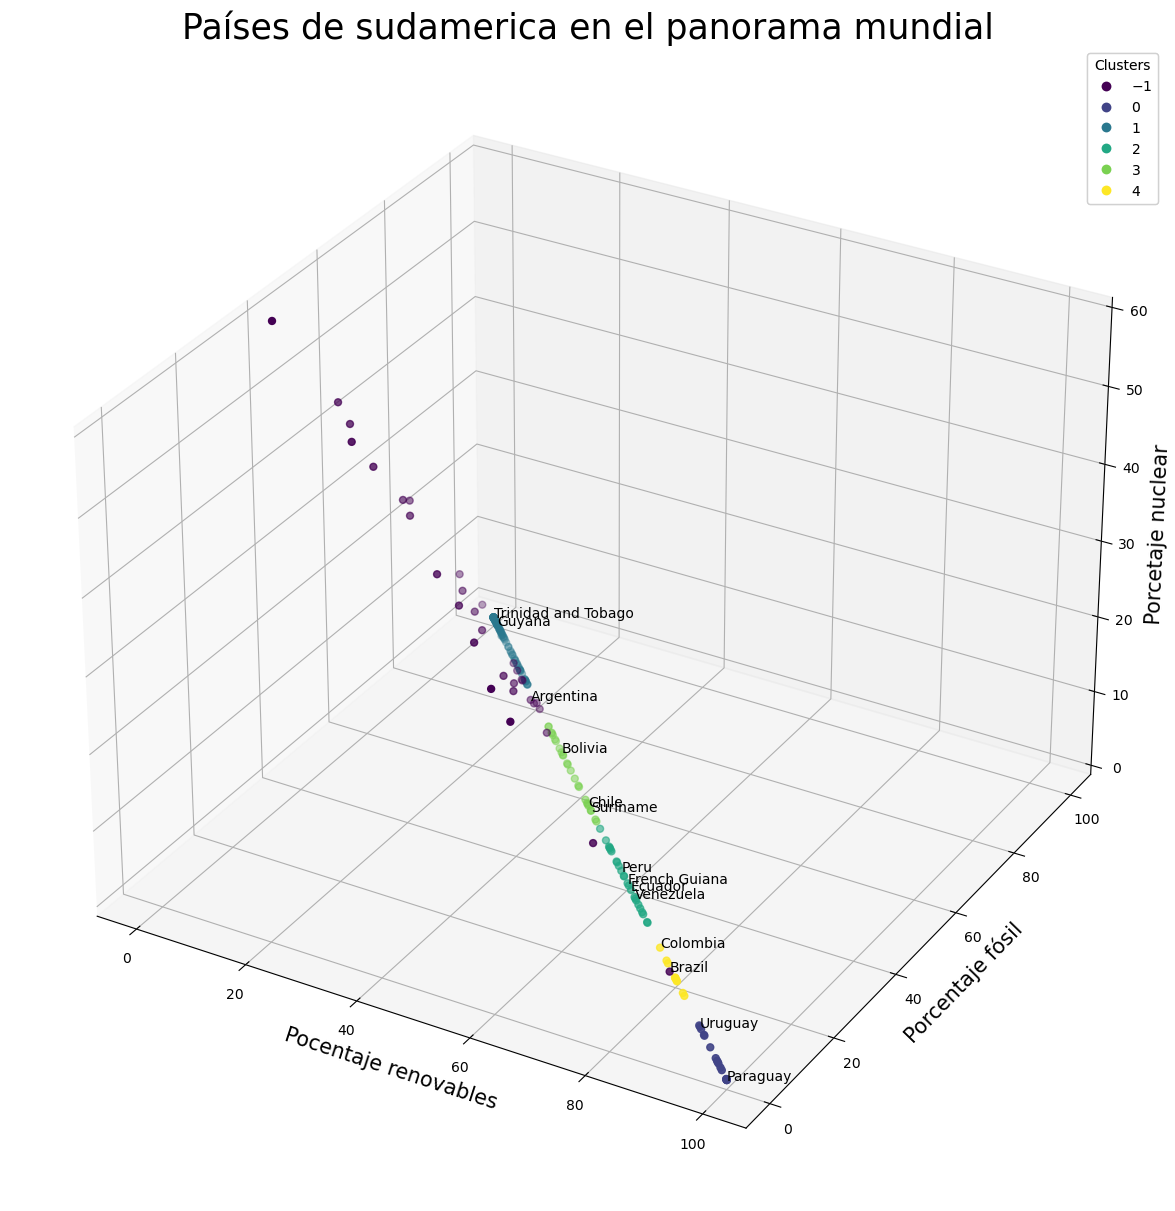

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['renewables_share_elec'], df['fossil_share_elec'], df['nuclear_share_elec'],
                     c=df['cluster'], cmap='viridis', s=25)

# Iterar a través de cada punto y agregar el texto correspondiente
for country, x, y, z in zip(suram['country'], suram['renewables_share_elec'], suram['fossil_share_elec'], suram['nuclear_share_elec']):
    ax.text(x, y, z, country, fontsize=10)
ax.set_xlabel('Pocentaje renovables', fontsize=15)
ax.set_ylabel('Porcentaje fósil', fontsize=15)
ax.set_zlabel('Porcetaje nuclear', fontsize=15)
ax.set_title('Países de sudamerica en el panorama mundial', fontsize=25)
ax.set_zlim(0, 60)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.show()

Observamos que los países de Sudamérica presentan diversidad de perfiles energéticos, con países agrupados en cada uno de los clusters arrojados por el modelo. En un extremo, países como Paraguay y Uruguay muestran gran independencia de los combustibles fósiles para electricidad. En el otro, países como Trinidad y Tobago y Granada muestran total dependencia de los combustibles fósiles. 

Argentina se ubica en el cluster -1. Desarrollo incipiente de energía nuclear para electricidad. 

## 6. Conclusiones

Podemos concluir que el algoritmo de DBSCAN nos permitió agrupar a los países del mundo según las distintas fuentes de las que obtienen electricidad para abastecer de electricidad a la población y la industria. 
<br> - Este agrupamiento arroja información sobre el nivel de dependencia que tiene cada país de las fuentes fósiles, pudiendo ir desde fuertemente dependiente hasta virtualmente independiente de las mismas. 
<br> - Las mayoría de los países que está en camino a lograr independencia de las fuentes fósiles lo logra a través de las fuentes de electricidad renovables (hidroeléctrica, solar, eólica, etc.) mientras que algunos pocos países lo logran a través de la electricidad de fuente nuclear. 

Es importante destacar que la electricidad consumida por un país es solo una parte de su consumo energético total, que también comprende el consumo de energía para transporte (mayoritariamente combustibles como nafta, gas y gasoil) y calefacción (que incluye combustibles como gas y kerosene). Los consumos para transporte y calefacción son más difíciles de independizar de fuentes fósiles que el consumo para electricidad, por lo que debe considerarse el perfil energético completo para sacar conclusiones sobre el nivel integral de dependencia de fuentes fósiles de cada país. 

## Producción de energías renovables

In [94]:
wec = pd.read_csv(r'../datasets/wec_s.csv')  
wec = wec[(wec['year'] > 2010)]

In [95]:
features_reg = ["country", "continente", "year", "population", "renewables_electricity", "nuclear_electricity", "low_carbon_electricity"]
wec = wec[features_reg]
wec.head(5)

,country,continente,year,population,renewables_electricity,nuclear_electricity,low_carbon_electricity
111,Afghanistan,Asia,2011,30.117,0.595,0.0,0.595
112,Afghanistan,Asia,2012,31.161,0.738,0.0,0.738
113,Afghanistan,Asia,2013,32.270,0.885,0.0,0.885
114,Afghanistan,Asia,2014,33.371,1.000,0.0,1.000
115,Afghanistan,Asia,2015,34.414,1.034,0.0,1.034


In [96]:
col_pais_cluster = ["country", "cluster"]
pais_cluster = df[col_pais_cluster]
pais_cluster.head(6)

,country,cluster
0,Afghanistan,4
1,Albania,0
2,Algeria,1
3,American Samoa,1
4,Angola,2
5,Antigua and Barbuda,1


Agregamos la columna cluster al dataset de metricas a lo largo de los años. 

In [97]:
wec2 = pd.merge(wec, pais_cluster, how = "left", on = "country")

Eliminamos las filas con cluster nulo, ya que corresponden a paises que no pudieron ser incorporados en el clustering por no contar con sus datos en el dataset. 

In [98]:
filas_nulos_cluster = wec2[wec2["cluster"].isnull()]
paises_nulos_cluster = filas_nulos_cluster["country"].unique()
paises_nulos_cluster # paises que no participaron del clustering

array(['Cape Verde', "Cote d'Ivoire", 'Eswatini', 'Faeroe Islands',
       'Kosovo', 'Macau', 'Myanmar', 'Netherlands Antilles',
       'North Macedonia', 'Northern Mariana Islands', 'Timor',
       'Western Sahara'], dtype=object)

In [99]:
wec2 = wec2[~wec2["country"].isin(paises_nulos_cluster)]

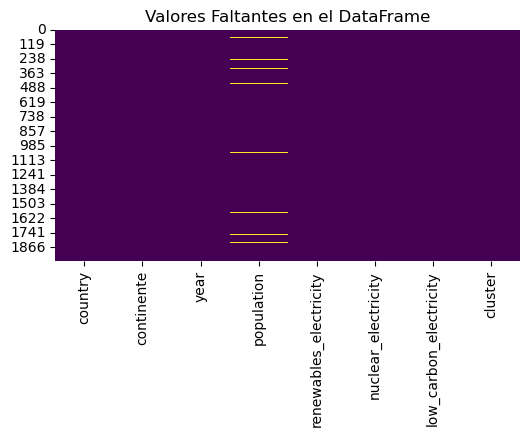

In [100]:
plt.figure(figsize=(6,3))
sns.heatmap(wec2.isnull(), cmap='viridis', cbar=False)
plt.title('Valores Faltantes en el DataFrame')
plt.show()

In [101]:
wec2 = wec2.dropna()

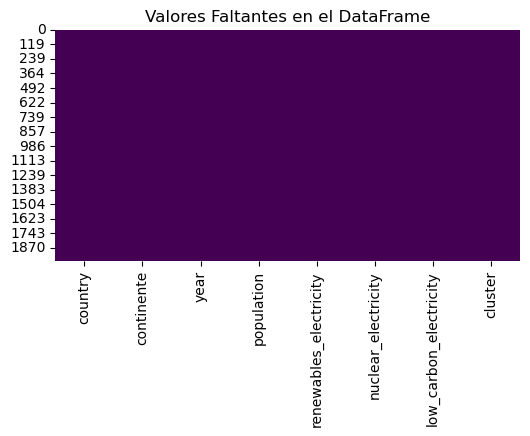

In [102]:
plt.figure(figsize=(6,3))
sns.heatmap(wec2.isnull(), cmap='viridis', cbar=False)
plt.title('Valores Faltantes en el DataFrame')
plt.show()

Agregamos la columna nivel_ingresos con datos del Banco Mundial. 
<br> LOW-INCOME ECONOMIES ($1,135 OR LESS), 
<br>  LOWER-MIDDLE INCOME ECONOMIES ($1,136 TO $4,465), 
<br> UPPER-MIDDLE-INCOME ECONOMIES ($4,466 TO $13,845),
<br> #HIGH-INCOME ECONOMIES ($13,846 OR MORE)


In [103]:
income_mapping = {
    'Afghanistan': 'bajo',    "North Korea": 'bajo',    'South Sudan': 'bajo',
    'Burkina Faso': 'bajo',    'Liberia': 'bajo',    'Sudan': 'bajo',
    'Burundi': 'bajo',    'Madagascar': 'bajo',    'Syria': 'bajo',    'Sao Tome and Principe':'bajo',	'Central African Republic': 'bajo', 'Saint Helena': 'bajo',
    'Malawi': 'bajo',    'Togo': 'bajo',    'Chad': 'bajo',    'Mali': 'bajo',    'Uganda': 'bajo',    'Congo, Dem. Rep': 'bajo',
    'Mozambique': 'bajo',    'Yemen': 'bajo',    'Eritrea': 'bajo',    'Niger': 'bajo',    'Ethiopia': 'bajo', 'Palestine': 'bajo',
    'Rwanda': 'bajo',    'Gambia': 'bajo',    'Sierra Leone': 'bajo',    'Guinea-Bissau': 'bajo',    'Somalia': 'bajo',
    'Angola': 'bajo-medio', 'Jordan': 'bajo-medio', 'Philippines': 'bajo-medio',
    'Algeria': 'bajo-medio', 'India': 'bajo-medio', 'Samoa': 'bajo-medio',
    'Bangladesh': 'bajo-medio', 'Iran': 'bajo-medio', 'São Tomé and Principe': 'bajo-medio',
    'Benin': 'bajo-medio', 'Kenya': 'bajo-medio', 'Senegal': 'bajo-medio',
    'Bhutan': 'bajo-medio', 'Kiribati': 'bajo-medio', 'Solomon Islands': 'bajo-medio',
    'Bolivia': 'bajo-medio', 'Kyrgyz Republic': 'bajo-medio', 'Sri Lanka': 'bajo-medio',
    'Cabo Verde': 'bajo-medio', 'Lao PDR': 'bajo-medio', 'Tanzania': 'bajo-medio',
    'Cambodia': 'bajo-medio', 'Lebanon': 'bajo-medio', 'Tajikistan': 'bajo-medio',
    'Cameroon': 'bajo-medio', 'Lesotho': 'bajo-medio', 'Timor-Leste': 'bajo-medio',
    'Comoros': 'bajo-medio', 'Mauritania': 'bajo-medio', 'Tunisia': 'bajo-medio',
    'Democratic Republic of Congo': 'bajo-medio', 'Congo': 'bajo-medio', 'Micronesia, Fed. Sts.': 'bajo-medio', 'Ukraine': 'bajo-medio',
    "Côte d'Ivoire": 'bajo-medio', 'Mongolia': 'bajo-medio', 'Uzbekistan': 'bajo-medio',
    'Djibouti': 'bajo-medio', 'Morocco': 'bajo-medio', 'Vanuatu': 'bajo-medio',
    'Egypt': 'bajo-medio', 'Myanmar': 'bajo-medio', 'Vietnam': 'bajo-medio',
    'Eswatini': 'bajo-medio', 'Nepal': 'bajo-medio', 'Zambia': 'bajo-medio',
    'Ghana': 'bajo-medio', 'Nicaragua': 'bajo-medio', 'Zimbabwe': 'bajo-medio',
    'Guinea': 'bajo-medio', 'Nigeria': 'bajo-medio',
    'Haiti': 'bajo-medio', 'Pakistan': 'bajo-medio',
    'Honduras': 'bajo-medio', 'Kyrgyzstan': 'bajo-medio', 'Papua New Guinea': 'bajo-medio',
    'Albania': 'medio-alto', 'Fiji': 'medio-alto', 'North Macedonia': 'medio-alto',
    'Argentina': 'medio-alto', 'Gabon': 'medio-alto', 'Palau': 'medio-alto',
    'Armenia': 'medio-alto', 'Georgia': 'medio-alto', 'Paraguay': 'medio-alto',
    'Azerbaijan': 'medio-alto', 'Grenada': 'medio-alto', 'Peru': 'medio-alto',
    'Belarus': 'medio-alto', 'Guatemala': 'medio-alto', 'Russia': 'medio-alto',
    'Belize': 'medio-alto', 'Indonesia': 'medio-alto', 'Serbia': 'medio-alto',
    'Bosnia and Herzegovina': 'medio-alto', 'Iraq': 'medio-alto', 'South Africa': 'medio-alto',
    'Botswana': 'medio-alto', 'Jamaica': 'medio-alto', 'St. Lucia': 'medio-alto',
    'Brazil': 'medio-alto', 'Kazakhstan': 'medio-alto', 'St. Vincent and the Grenadines': 'medio-alto',
    'Bulgaria': 'medio-alto', 'Kosovo': 'medio-alto', 'Czechia': 'medio-alto','Suriname': 'medio-alto',
    'China': 'medio-alto', 'Laos': 'medio-alto','Libya': 'medio-alto', 'Thailand': 'medio-alto',
    'Colombia': 'medio-alto', 'Malaysia': 'medio-alto', 'Tonga': 'medio-alto',
    'Costa Rica': 'medio-alto', 'Maldives': 'medio-alto', 'Türkiye': 'medio-alto',
    'Cuba': 'medio-alto', 'Marshall Islands': 'medio-alto', 'Turkmenistan': 'medio-alto',
    'Dominica': 'medio-alto', 'Mauritius': 'medio-alto', 'Tuvalu': 'medio-alto',
    'Dominican Republic': 'medio-alto', 'Mexico': 'medio-alto', 'West Bank and Gaza': 'medio-alto',
    'El Salvador': 'medio-alto', 'Moldova': 'medio-alto',
    'Equatorial Guinea': 'medio-alto', 'Martinique': 'medio-alto', 'Montenegro': 'medio-alto', 'Venezuela': 'medio-alto',
    'Ecuador': 'medio-alto', 'Namibia': 'medio-alto', 'Turkey': 'medio-alto',
    'American Samoa': 'alto', 'Guadeloupe': 'alto', 'Germany': 'alto', 'Oman': 'alto',
    'Andorra': 'alto', 'Gibraltar': 'alto', 'Panama': 'alto',
    'Antigua and Barbuda': 'alto', 'Greece': 'alto', 'Poland': 'alto',
    'Aruba': 'alto', 'Greenland': 'alto', 'Portugal': 'alto',
    'Australia': 'alto', 'Guam': 'alto', 'Puerto Rico': 'alto',
    'Austria': 'alto', 'Hong Kong': 'alto', 'Qatar': 'alto',
    'Bahamas': 'alto', 'Hungary': 'alto', 'Romania': 'alto',
    'Bahrain': 'alto', 'Iceland': 'alto', 'San Marino': 'alto',
    'Barbados': 'alto', 'Ireland': 'alto', 'Saudi Arabia': 'alto',
    'Belgium': 'alto', 'Isle of Man': 'alto', 'Seychelles': 'alto',
    'Bermuda': 'alto', 'Israel': 'alto', 'Singapore': 'alto',
    'British Virgin Islands': 'alto', 'Italy': 'alto', 'Sint Maarten (Dutch part)': 'alto',
    'Brunei': 'alto', 'Japan': 'alto', 'Slovakia': 'alto',
    'Canada': 'alto', 'South Korea': 'alto', 'Slovenia': 'alto',
    'Cayman Islands': 'alto', 'Kuwait': 'alto', 'Spain': 'alto',
    'Channel Islands': 'alto', 'Cook Islands': 'alto', 'Latvia': 'alto', 'St. Kitts and Nevis': 'alto',
    'Chile': 'alto', 'Liechtenstein': 'alto', 'St. Martin (French part)': 'alto',
    'Croatia': 'alto', 'Lithuania': 'alto', 'Sweden': 'alto',
    'Curaçao': 'alto', 'Luxembourg': 'alto', 'Switzerland': 'alto',
    'Cyprus': 'alto', 'Macao SAR, China': 'alto', 'Taiwan': 'alto',
    'Czech Republic': 'alto', 'Malta': 'alto', 'Trinidad and Tobago': 'alto',
    'Denmark': 'alto', 'Monaco': 'alto', 'Turks and Caicos Islands': 'alto',
    'Estonia': 'alto', 'Nauru': 'alto', 'United Arab Emirates': 'alto',
    'Faroe Islands': 'alto', 'Netherlands': 'alto', 'United Kingdom': 'alto',
    'Finland': 'alto', 'New Caledonia': 'alto', 'Montserrat': 'alto', 'United States': 'alto',
    'France': 'alto', 'New Zealand': 'alto', 'Niue': 'alto', 'Uruguay': 'alto',
    'French Polynesia': 'alto', 'French Guiana': 'alto', 'Northern Mariana Islands': 'alto', 'United States Virgin Islands': 'alto',
    'Guyana': 'alto', 'Norway': 'alto', 'Saint Kitts and Nevis': 'alto', 'Saint Lucia': 'alto', 'Saint Pierre and Miquelon':	'alto', 
    'Saint Vincent and the Grenadines':	'alto'
}



In [104]:
wec2['nivel_ingresos'] = wec2['country'].map(income_mapping)

In [105]:
wec2.to_csv("../datasets/wec_reg_lineal", index= False)